<a href="https://colab.research.google.com/github/nidhaloff/Beer-Consumption/blob/univariate/Copy_of_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [557]:
import keras
from keras import backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score

%matplotlib inline

# run keras model on google GPU
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [558]:
dataset = pd.read_csv('/content/Consumo_cerveja.csv')
print(dataset.columns)
print(dataset.describe())

Index(['Data', 'Temperatura Media (C)', 'Temperatura Minima (C)',
       'Temperatura Maxima (C)', 'Precipitacao (mm)', 'Final de Semana',
       'Consumo de cerveja (litros)'],
      dtype='object')
       Final de Semana  Consumo de cerveja (litros)
count       365.000000                   365.000000
mean          0.284932                    25.401367
std           0.452001                     4.399143
min           0.000000                    14.343000
25%           0.000000                    22.008000
50%           0.000000                    24.867000
75%           1.000000                    28.631000
max           1.000000                    37.937000


In [0]:
dataset = dataset[:365]    # ignore all the non value cells

In [0]:
# translate column names
dataset.columns = ('Date', 'Medium', 'Min', 'Max', 'Precipitation', 'Weekend', 'Consumption')

In [561]:
dataset.head(5)

,Date,Medium,Min,Max,Precipitation,Weekend,Consumption
0,2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
4,2015-01-05,"23,82",21,"28,3",0,0.0,28.900


In [562]:
def convert_to_float(features):
    for feature in features:
        dataset[feature] = dataset[feature].str.replace(',', '.').astype(float)

convert_to_float(["Medium", "Min", "Max", "Precipitation"])
dataset.head(5)

,Date,Medium,Min,Max,Precipitation,Weekend,Consumption
0,2015-01-01,27.30,23.9,32.5,0.0,0.0,25.461
1,2015-01-02,27.02,24.5,33.5,0.0,0.0,28.972
2,2015-01-03,24.82,22.4,29.9,0.0,1.0,30.814
3,2015-01-04,23.98,21.5,28.6,1.2,1.0,29.799
4,2015-01-05,23.82,21.0,28.3,0.0,0.0,28.900


In [563]:
dataset.isna().sum()

Date             0
Medium           0
Min              0
Max              0
Precipitation    0
Weekend          0
Consumption      0
dtype: int64

In [0]:
# alright we have no missed values there
date_column = dataset.pop('Date')

In [565]:
date_column = pd.to_datetime(date_column)
date_column.head(5)

0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: Date, dtype: datetime64[ns]

In [0]:
dataset['Day'] = date_column.dt.day

In [0]:
dataset['Month'] = date_column.dt.month
dataset['Year'] = date_column.dt.year

In [568]:
dataset.head(5)

,Medium,Min,Max,Precipitation,Weekend,Consumption,Day,Month,Year
0,27.30,23.9,32.5,0.0,0.0,25.461,1,1,2015
1,27.02,24.5,33.5,0.0,0.0,28.972,2,1,2015
2,24.82,22.4,29.9,0.0,1.0,30.814,3,1,2015
3,23.98,21.5,28.6,1.2,1.0,29.799,4,1,2015
4,23.82,21.0,28.3,0.0,0.0,28.900,5,1,2015


In [569]:
dataset.shape

(365, 9)

In [0]:
def plot_correlation_matrix(data):
    plt.figure(figsize=(10, 10))
    top_features = data.corr().index
    color = plt.get_cmap('RdYlGn')
    color.set_bad('lightblue')
    sns.heatmap(data[top_features].corr(), annot=True, cmap=color)

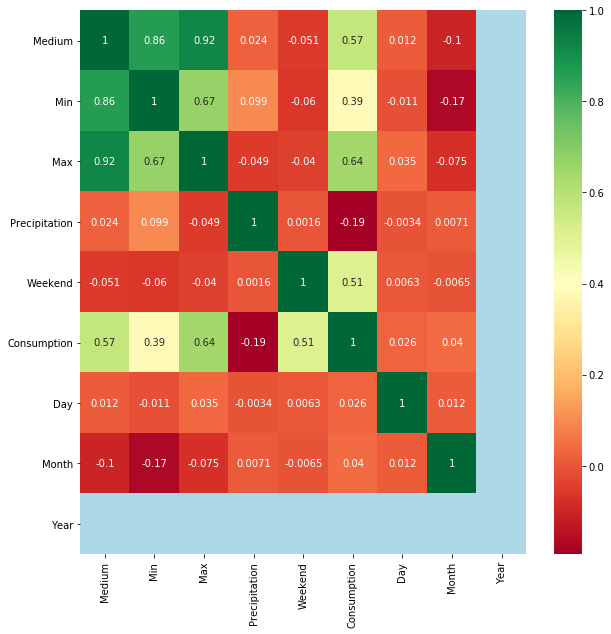

In [571]:
plot_correlation_matrix(dataset)

In [0]:
dataset.drop('Year', axis=1, inplace=True)   # year is the same for all rows and thus we dont need it

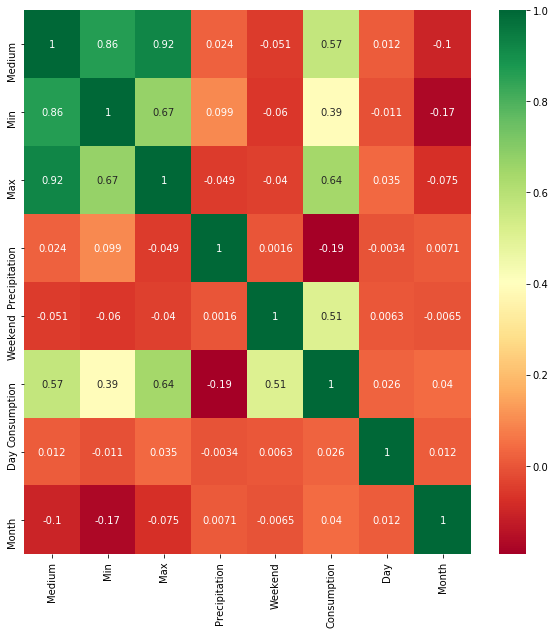

In [573]:
plot_correlation_matrix(dataset)

In [574]:
dataset.Precipitation.replace(to_replace=0, value=dataset.Precipitation.mean(), inplace=True)   # fill missed values in the Precipitation feature

def normalize_data(features=["Min", "Max", "Precipitation", "Day", "Month"], normalize_output=False):
    if normalize_output:
        dataset["Consumption"] = (dataset["Consumption"] - dataset["Consumption"].mean()) / dataset["Consumption"].std()
    for feature in features:
        dataset[feature] = (dataset[feature] - dataset[feature].mean()) / dataset[feature].std()

normalize_data(normalize_output=False)
dataset.head(5)

,Medium,Min,Max,Precipitation,Weekend,Consumption,Day,Month
0,27.30,2.278205,1.363909,-0.273944,0.0,25.461,-1.671209,-1.600548
1,27.02,2.490506,1.595532,-0.273944,0.0,28.972,-1.557680,-1.600548
2,24.82,1.747455,0.761690,-0.273944,1.0,30.814,-1.444151,-1.600548
3,23.98,1.429004,0.460580,-0.626699,1.0,29.799,-1.330622,-1.600548
4,23.82,1.252087,0.391093,-0.273944,0.0,28.900,-1.217093,-1.600548


In [575]:
def split_trainingset(dataset, feature=None):
    # turn the regression to univariate with setting the feature argument
    y = dataset.pop('Consumption')
    if not feature:
        X = dataset
    else:
        X = dataset[feature]

    X.fillna(X.mean(), inplace=True)
    y.fillna(y.mean(), inplace=True)
    X, y = X.to_numpy().astype(np.float32), y.to_numpy().astype(np.float32)
    y = y.reshape(-1, 1)
    
    if feature:
        X = X.reshape(-1, 1)

    print(X.shape, y.shape, type(X), type(y))
    return X, y

X, y = split_trainingset(dataset, feature="Medium")

(365, 1) (365, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [0]:
# convert numpy to tensors
X = torch.from_numpy(X)
y = torch.from_numpy(y)


In [577]:
trainset = TensorDataset(X, y)
loader = DataLoader(trainset, batch_size=32, shuffle=True) 
print(X.shape)

torch.Size([365, 1])


In [0]:
class Net(nn.Module):
    def __init__(self, n_features=X.shape[1], n_out=1):
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_out)
        # self.fc2 = nn.Linear(20, n_out)
        # self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        # out = self.fc2(out)
        return out

In [0]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr=0.00001)
criterion = nn.MSELoss()

def training_func(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        out = model(x)
        # Computes loss
        loss = loss_fn(out, y)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [0]:
train = training_func(model, criterion, optimizer)

def fit(epochs=100):
    losses, iters= [], []
    count = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train(x, y)
            count += 1
            if count % 50 == 0:
                losses.append(loss)
                iters.append(count)

    return losses, iters


[12.318857192993164, 11.119576454162598, 9.445330619812012, 11.212627410888672]
[50, 100, 150, 200, 250]


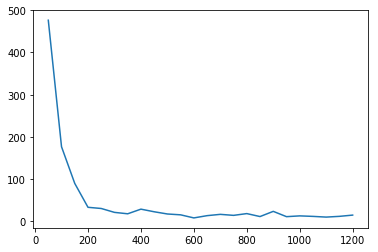

In [581]:
losses, iters = fit(100)
print(losses[-5:-1])
print(iters[:5])
plt.plot(iters, losses)
plt.show()


In [582]:
def test():
    model.eval()
    
    losses = []
    count = 0
    with torch.no_grad():
        
        for X_test, y_test in loader:
            
            out = model(X_test)
            loss = criterion(out, y_test)
            losses.append(loss)
    return losses

val_losses = test()
print(val_losses)
print("average loss: ", sum(val_losses) / len(val_losses))


[tensor(10.1555), tensor(16.4905), tensor(19.4729), tensor(15.4538), tensor(13.3810), tensor(8.7479), tensor(12.2863), tensor(16.6429), tensor(15.2377), tensor(14.1161), tensor(17.8891), tensor(6.6147)]
average loss:  tensor(13.8740)


In [0]:
def plot_result(model, x, y):
    with torch.no_grad():
        pred = model(x)
        pred = pred.detach().numpy()
        x = x.detach().numpy()
        y = y.detach().numpy()
        print(pred.shape, y.shape)
        # w, b = model.parameters()
        # w = w.detach().numpy()
        # b = b.detach().numpy()
        # best_fit = x * w + b
        x_ax = np.arange(0, len(x))
        plt.scatter(x, y, marker="o", cmap='b')
        # plt.scatter(x, pred, marker="P", cmap='g')
        plt.plot(x, pred, color='red')
        plt.show()


(365, 1) (365, 1)


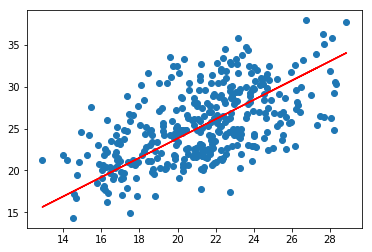

In [584]:
plot_result(model, X, y)